In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
#Data processing
from sklearn.preprocessing import MinMaxScaler

## Data Injest

In [2]:
PATH = "../notebooks/dual_sen_sample_1.csv"

In [3]:
def moving_mean(time, data, lag=5):
    X = []
    y = []
    y_std = []
    for i in range(int(len(data)/lag)):
        X.append(time[(i*lag+lag)])
        y.append(np.mean(data[(i*lag):(i*lag+lag)]))
        y_std.append(np.std(data[(i*lag):(i*lag+lag)]))
        
    return X, y, y_std

In [4]:
df = pd.read_csv(PATH,parse_dates=['datetime','date'])

df.drop(['date','time','r_sen_1','s_sen_1','s_sen_2'],axis=1,inplace=True)
# df["mvg20_sen_2"] = df.loc[:,"r_sen_2"].rolling(window=20).mean()
# df["mvg20_sen_2"] = df["mvg20_sen_2"].round()
x, y, y_err = moving_mean(df['datetime'],df["r_sen_2"], 20)
df.loc[df['datetime'].isin(x),'avg20_sen_2'] = y
df.loc[df['datetime'].isin(x),'std20_sen_2'] = y_err
df.dropna(inplace=True)
df.head()

,datetime,r_sen_2,avg20_sen_2,std20_sen_2
20,2020-08-12 15:12:11,630,630.0,0.0
40,2020-08-12 15:32:11,630,630.0,0.0
60,2020-08-12 15:52:11,630,630.0,0.0
80,2020-08-12 16:12:11,630,630.0,0.0
100,2020-08-12 16:32:11,630,630.0,0.0


## Data visual

In [5]:
df_w = df.loc[df['std20_sen_2'] > 15]
df_t = pd.DataFrame(data={'datetime':pd.to_datetime("2020-08-07 13:40:31"),'r_sen_2':np.average(df_w['r_sen_2']), 'avg20_sen_2':np.average(df_w['avg20_sen_2']),'std20_sen_2':np.average(df_w['std20_sen_2'])},index=[0])
df_t = df_t.append(df_w)
df_t.sort_values(['datetime'],ascending=False,inplace=True)


for r_i, r_d in df.iterrows():
    for idx, row in df_t.iterrows():
        if r_d.datetime >= row.datetime:
            df.loc[r_i,'last_water'] = r_d.datetime - row.datetime
            break
        else:
            next

df['dow'] = df.datetime.dt.dayofweek
df.reset_index(inplace=True)
df.index = df.datetime
df.drop("datetime",axis=1,inplace=True)
df.dropna(inplace=True)
df_w

,datetime,r_sen_2,avg20_sen_2,std20_sen_2
5980,2020-08-16 18:28:31,428,573.70,98.068395
21540,2020-08-27 13:37:31,498,466.15,26.439128
35740,2020-09-06 10:11:53,425,469.40,93.473205
47400,2020-09-14 12:23:49,418,501.60,117.408432


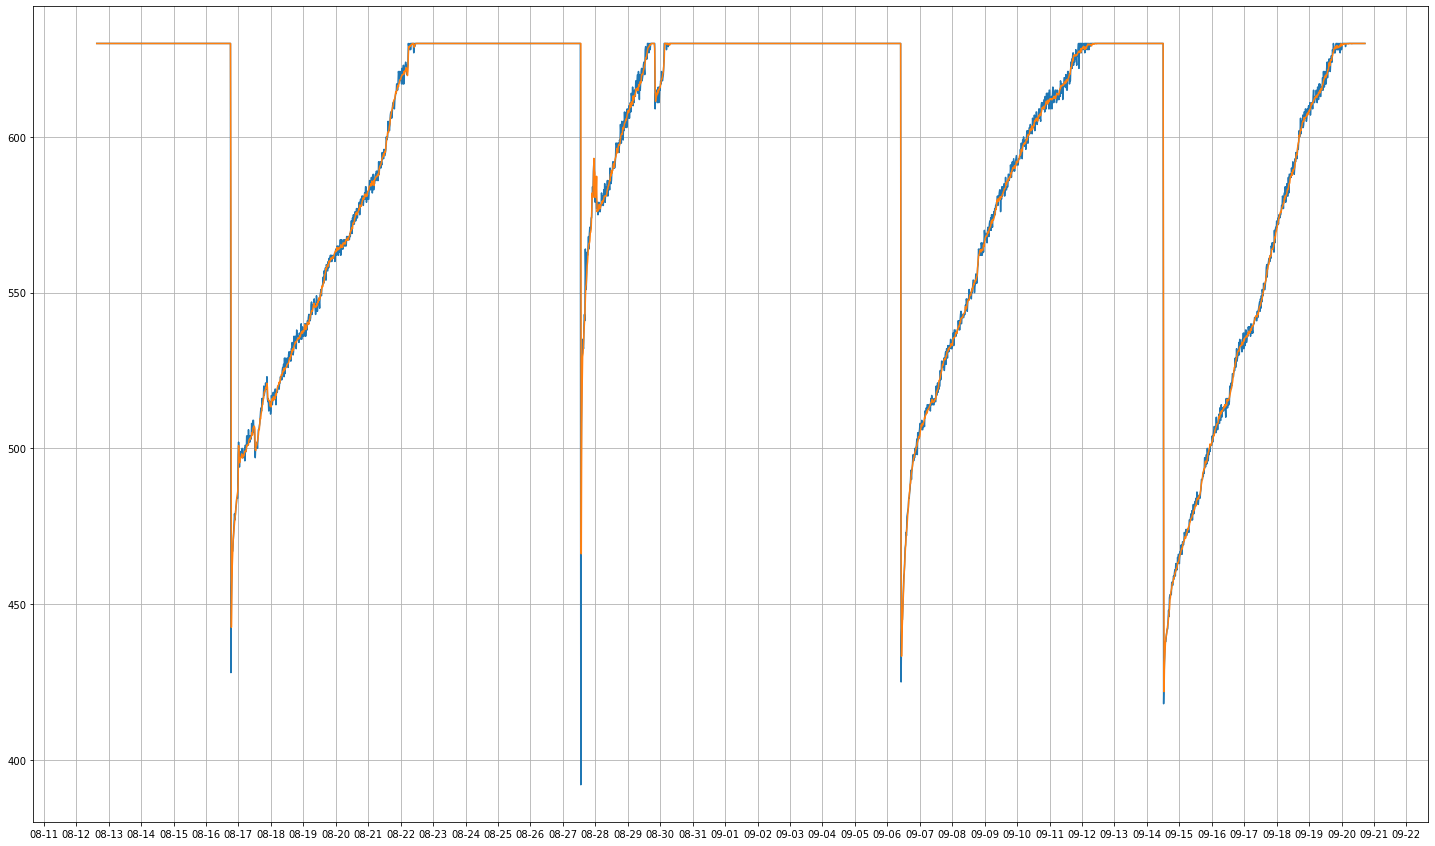

In [6]:
df_ts = df.copy()

fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(df_ts.loc[:,'r_sen_2'],label='data')
ax.plot(df_ts.loc[:,'avg20_sen_2'],label='avgd')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
plt.show()

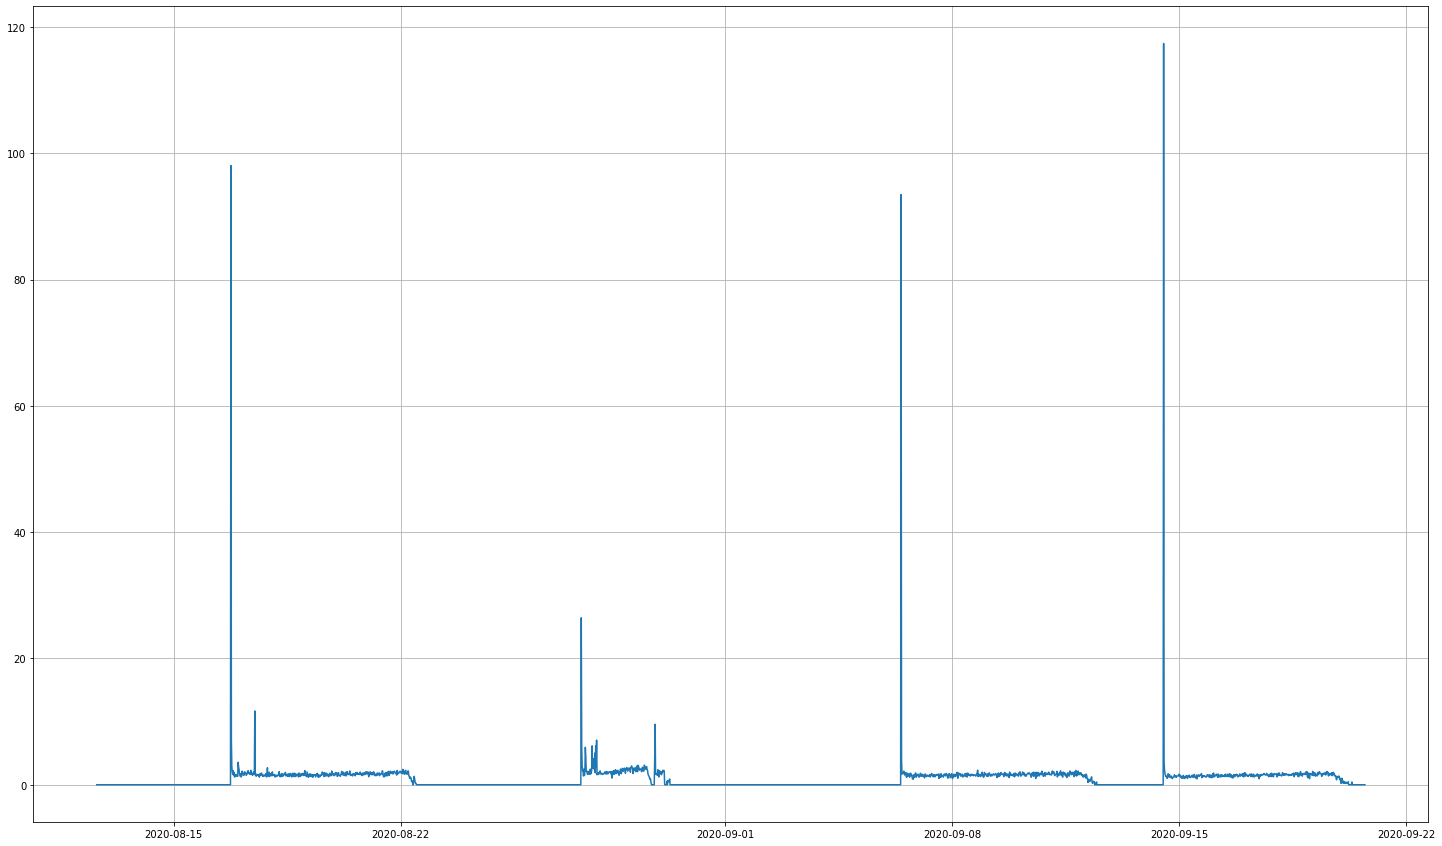

In [7]:
fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(df_ts['std20_sen_2'])
plt.show()

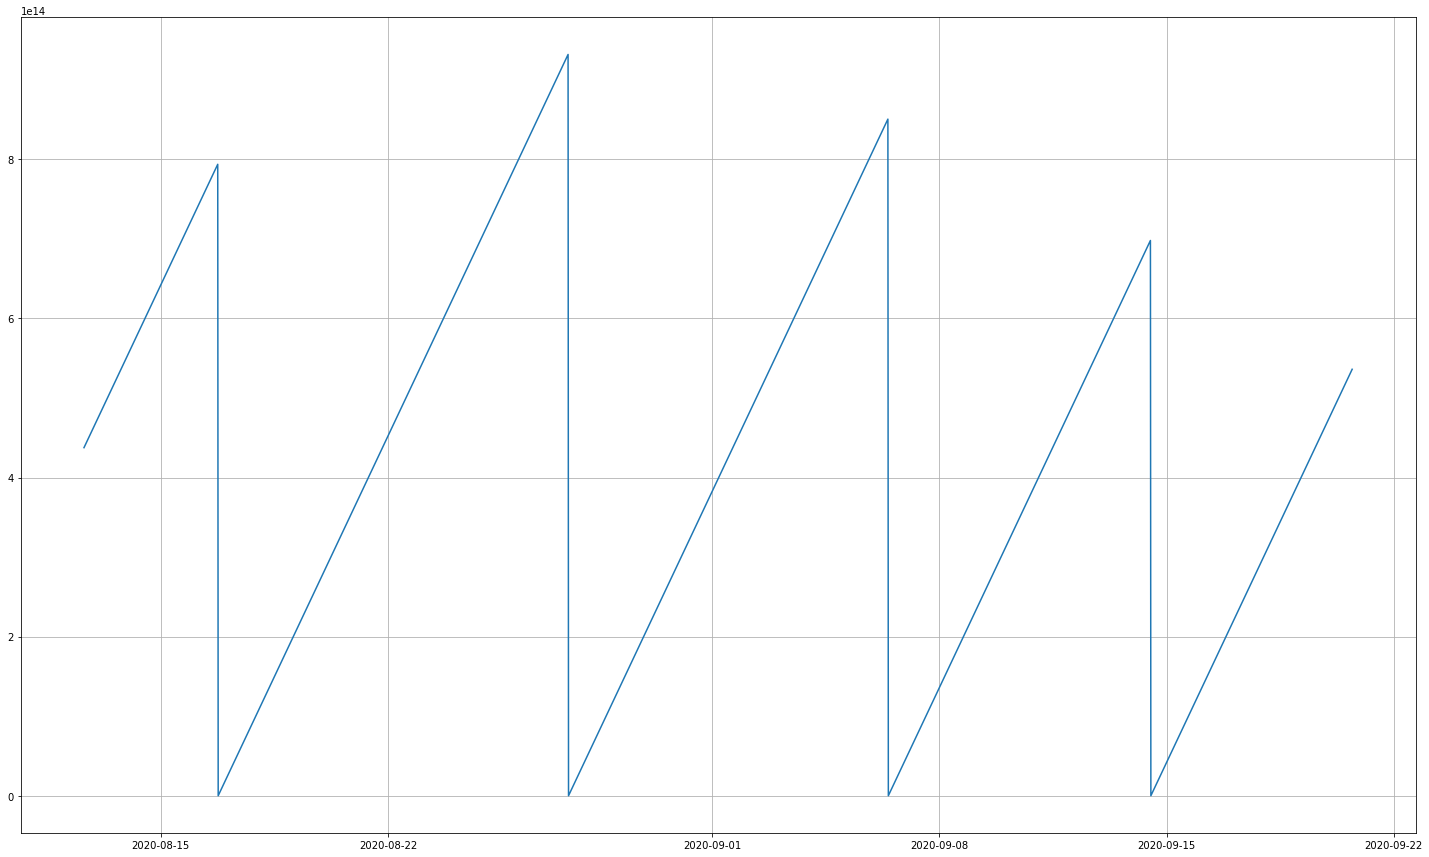

In [8]:
fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(df_ts['last_water'])
plt.show()

In [9]:
df.head()

,index,r_sen_2,avg20_sen_2,std20_sen_2,last_water,dow
datetime,,,,,,
2020-08-12 15:12:11,20,630,630.0,0.0,5 days 01:31:40,2
2020-08-12 15:32:11,40,630,630.0,0.0,5 days 01:51:40,2
2020-08-12 15:52:11,60,630,630.0,0.0,5 days 02:11:40,2
2020-08-12 16:12:11,80,630,630.0,0.0,5 days 02:31:40,2
2020-08-12 16:32:11,100,630,630.0,0.0,5 days 02:51:40,2


## Data processing

In [38]:
def ds_make(df,y_col,win=20):    
    x, y = [], []
    for i in range(int(len(df)-win-1)):
        a = df.loc[i:(i+win)-1]
        x.append(a)
        y.append(df.loc[i+win])
    return np.array(x), np.array(y)

In [113]:
df_d = df.reset_index()
df_d.drop('index',axis=1,inplace=True)

df_d.loc[:,'datetime'] = df_d['datetime'].astype(int)/1000000000
df_d.loc[:,'last_water'] = df_d.loc[:,'last_water'].astype(int)/1000000000

#scale down for computing
scaler = MinMaxScaler(feature_range=(0,1))
for col in df_d.columns:
    df_d.loc[:,col] = scaler.fit_transform(df_d[col].values.reshape(-1,1))

# split into DL data
xs, ys = ds_make(df_d,"r_sen_2")

In [114]:
xs

array([[[0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.69551592e-01, 3.33333333e-01],
        [3.55329934e-04, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.70839505e-01, 3.33333333e-01],
        [7.10659868e-04, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.72127418e-01, 3.33333333e-01],
        ...,
        [6.04060888e-03, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.91446112e-01, 3.33333333e-01],
        [6.39593882e-03, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.92734025e-01, 3.33333333e-01],
        [6.75126875e-03, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.94021937e-01, 3.33333333e-01]],

       [[3.55329934e-04, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.70839505e-01, 3.33333333e-01],
        [7.10659868e-04, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         4.72127418e-01, 3.33333333e-01],
        [1.06598980e-03, 1.00000000e+00, 1.00000000e+00, 0.000000

## Data loader

Reference


https://towardsdatascience.com/how-to-use-deep-learning-for-time-series-forecasting-3f8a399cf205